# Anomaly Detection and Change Point Detection - Reproduced

by [Frank Jung](https://www.linkedin.com/in/frankjung/)

---

![Anomaly Detection and Change Point Detection - Reproduced](anomaly-detection-reproduced.png)

Anomalies are patterns in the data that do not conform to a well-defined notion of normal behavior.

Techniques used to detection anomalies typically require training before using on new data. 

Here we will reproduce the results from [Oana Niculaescu](https://www.linkedin.com/in/oana-niculaescu-1aa72b53/)'s article in [XRDS](https://xrds.acm.org/), [Applying Data Science for Anomaly and Change Point Detection](http://xrds.acm.org/article.cfm?aid=3265925).

This reproduction was generated using a Jupyter Notebook. The notebook is available [here](https://github.com/frankhjung/jupyter-anomaly-detection).

## Detecting Changes

The [CUSUM](https://en.wikipedia.org/wiki/CUSUM) algorithm is used to test for anomalies. This requires two parameters: *threshold* and *drift*. But, how do you choose values for these parameters? Gustafsson (2000) provides this recipe:

* Start with a very large *threshold*.
* Choose *drift* to one half of the expected change, or adjust drift such that `g = 0` more than 50% of the time.
* Then set the *threshold* so the required number of false alarms (this can be done automatically) or delay for detection is obtained.
* If faster detection is sought, try to decrease *drift*.
* If fewer false alarms are wanted, try to increase *drift*.
* If there is a subset of the change times that does not make sense, try to increase *drift*.

The article by Niculaescu did not provide the source for the CUSUM algorithm used. However, I believe it may have been [this](http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb) one from [Marcos Duarte](https://www.researchgate.net/profile/Marcos_Duarte4).

We will use that implementation of the CUSUM algorithm to detect changes in data.

### A Python Implementation of the CUSUM Algorithm

Load dependencies and report versions:

In [10]:
import sys
print("Python version:", sys.version, "on platform:", sys.platform)

import pandas as pd
print("pandas version:", pd.__version__)

import numpy as np
print("NumPy version:", np.__version__)

import sklearn
print("scikit-learn version:", sklearn.__version__)

Python version: 3.13.8 (main, Oct  7 2025, 15:35:51) [Clang 20.1.4 ] on platform: linux
pandas version: 2.3.3
NumPy version: 2.4.1
scikit-learn version: 1.8.0


Declare CUSUM algorithm by Duarte:

In [11]:
from __future__ import division, print_function
import numpy as np

"""
Source: http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb
"""

"""Cumulative sum algorithm (CUSUM) to detect abrupt changes in data."""


__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

### Example

Before we reproduce the results by Niculaescu, lets explore Duarte's CUSUM implementation.

This example is from Duarte's [notebook](http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb) above. It introduces an anomaly between observations 100 and 200:

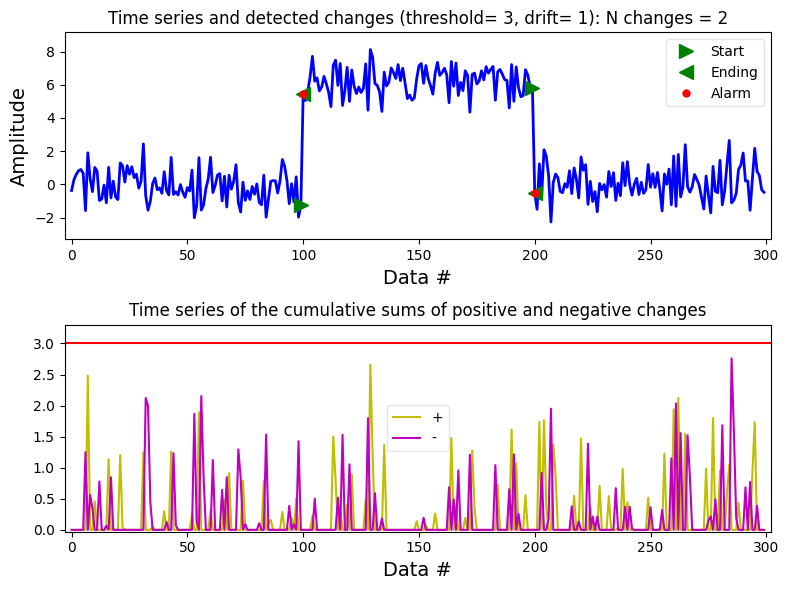

(array([100, 200]),
 array([ 99, 199]),
 array([100, 200]),
 array([ 6.71988323, -6.35497604]))

In [3]:
x = np.random.randn(300)
x[100:200] += 6
detect_cusum(x, threshold=3.0, drift=1.0, ending=True, show=True)

After trial and error, a reasonable *threshold* (3.0) and *drift* (1.0) were found.

## Processing Latency and Throughput Data

The following sections will be a re-construction of the Niculaescu's results.

### Load Example Data

Load Niculaescu's example data from [GitHub](https://github.com/):

Here *throughput* and *latency* are measured in milliseconds.

In [4]:
# load csv from github
url = "https://raw.githubusercontent.com/elf11/XRDS/master/tr_server_data.csv"
# throughput and latency measured in milliseconds
server_csv = pd.read_csv(url, header = 0, names = ["throughput", "latency"])
server = pd.DataFrame(server_csv)

In [5]:
print("Server data sample contains %d rows and %d columns." % server.shape)

Server data sample contains 306 rows and 2 columns.


### Plot Data

Plot data to visualise outliers:

<Axes: xlabel='throughput', ylabel='latency'>

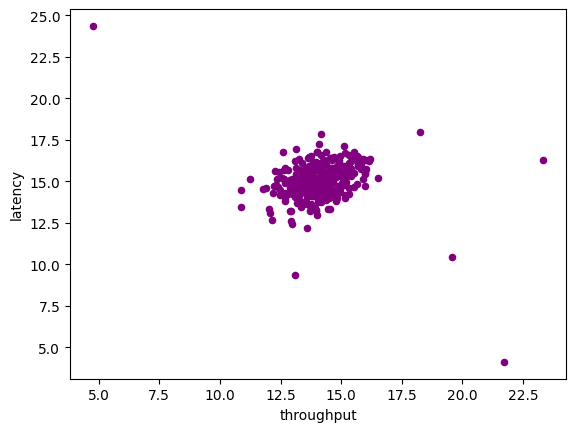

In [6]:
server.plot.scatter(x = "throughput", y = "latency", c = "purple")

Next we will attempt to identify outliers in this data. To do that we need to choose  appropriate values for *threshold* and *drift*.

### Trial 1

Test *latency*, where we ignore our previous advice and start low with:

* threshold = 1
* drift = 0.1

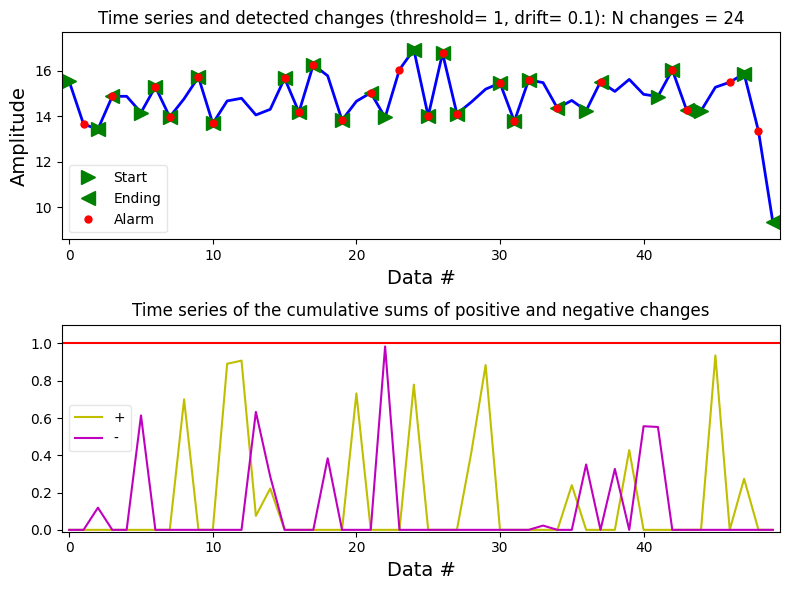

In [7]:
trial1 = detect_cusum(server.latency[250:300], threshold=1, drift=0.1, ending=True, show=True)

Here the test is too sensitive.

### Trial 2

Test *latency*, where:

* threshold = 4
* drift = 1.0

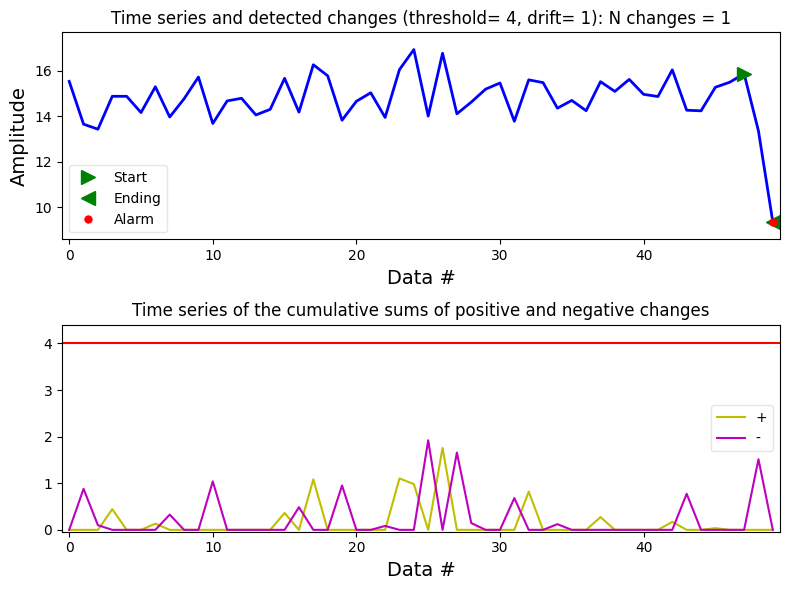

In [8]:
trial2 = detect_cusum(server.latency[250:300], threshold=4, drift=1.0, ending=True, show=True)

Here the *threshold* and *drift* seem to be optimal.

### Validate

Now that we have a good *threshold* and *drift*, lets validate itagainst the full data set.

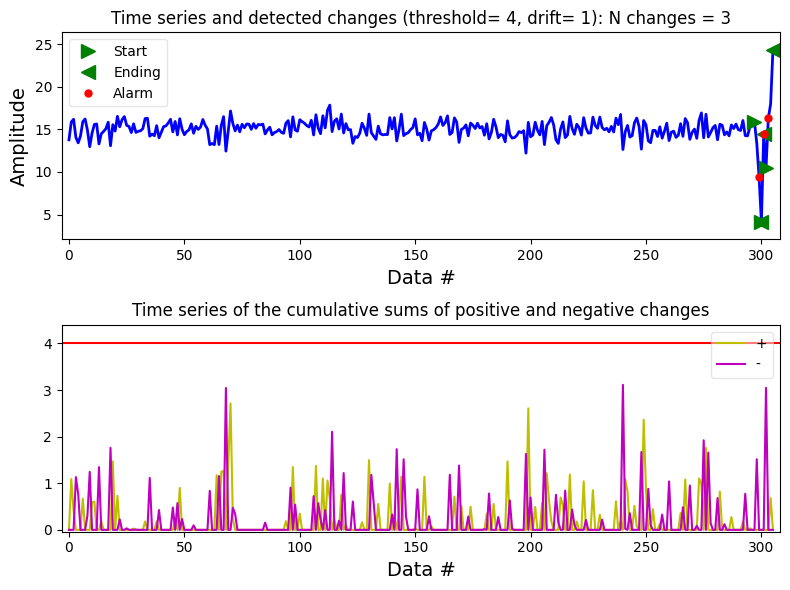

In [9]:
validate = detect_cusum(server.latency, threshold=4, drift=1.0, ending=True, show=True)

## Summary

We have used trial an error to guess appropriate values for *threshold* and *drift*.
Is there a better way to select appropriate values for the parameters?

In Eleazar Eskin ([2000](https://academiccommons.columbia.edu/download/fedora_content/download/ac:125814/content/anomaly-icml00.pdf)), it appears that this can be done. We will look at this next.

## References

* [GitHub repository for this notebook](https://github.com/frankhjung/jupyter-anomaly-detection)

* Oana Niculaescu. 2018. Applying data science for anomaly and change point detection. XRDS 25, 1 (October 2018), 70-73. DOI: https://doi.org/10.1145/3265925

* Data from https://github.com/elf11/XRDS/blob/master/tr_server_data.csv

* Eleazar Eskin. 2000. Anomaly Detection over Noisy Data using Learned Probability Distributions. In Proceedings of the Seventeenth International Conference on Machine Learning (ICML '00), Pat Langley (Ed.). Morgan Kaufmann Publishers Inc., San Francisco, CA, USA, 255-262. ([PDF](https://academiccommons.columbia.edu/download/fedora_content/download/ac:125814/content/anomaly-icml00.pdf))

* https://en.wikipedia.org/wiki/F1_score

* Cumulative Sum control chart: https://en.wikipedia.org/wiki/CUSUM

* Detection of changes using the Cumulative Sum (CUSUM): http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

* Adaptive Filtering and
Change Detection by Fredrik Gustafsson (2000): https://eden.dei.uc.pt/~tbohnert/math/ap-cp.pdf
